In [1]:
import pandas as pd

DATA_FILE = '../../data/chimpanzees.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


### Code 11.2

In [3]:
df['treatment'] = df['prosoc_left'] + 2 * df['condition']
df[['condition', 'prosoc_left', 'treatment']].drop_duplicates()

,condition,prosoc_left,treatment
0,0,0,0
2,0,1,1
36,1,0,2
38,1,1,3


In [4]:
df['actor'].drop_duplicates()

0      1
72     2
144    3
216    4
288    5
360    6
432    7
Name: actor, dtype: int64

## Model

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha_{\text{actor}[i]} + \beta_{\text{treatment}[i]} \\
    \alpha_j & \sim \text{to be determined} \\
    \beta_j & \sim \text{to be determined}
\end{align*}

Here $L$ indicates the binary variable `pulled_left`; there are $7$ `$\alpha$ parameters`, one for each chimpanzee; there are $4$ `treatment` variables, one for each combination of the position of the pro-social option and the presence/absence of a partner.

## Priors for $\alpha$

The very first attempt consists of using a flat prior for $\alpha$.

\begin{align*}
    L_i & \sim \text{Binomial}(1, p_i) \\
    \log \frac{p_i}{1 - p_i} & = \alpha  \\
    \alpha & \sim \text{Normal}(0, \omega)
\end{align*}


In [5]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

### Code 11.4 - 11.6

In [6]:
with pm.Model() as m_11_1:
    a = pm.Normal('a', mu=0, sigma=10)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1 = pm.sample_prior_predictive(4000)

In [7]:
prior_11_1

{'p': array([9.36261079e-11, 9.99967031e-01, 9.82128121e-01, ...,
        9.93814020e-01, 9.99998636e-01, 9.99319036e-01]),
 'a': array([-23.09171421,  10.31991447,   4.00649331, ...,   5.07926472,
         13.50501942,   7.29131981]),
 'pulled_left': array([[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])}

In [8]:
with pm.Model() as m_11_1_base:
    a = pm.Normal('a', mu=0, sigma=1.5)
    p = pm.Deterministic('p', pm.math.invlogit(a))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_1_base = pm.sample_prior_predictive(4000)

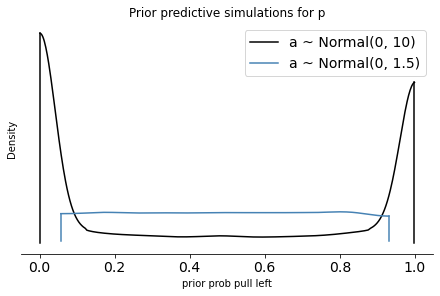

In [9]:
az.plot_density([prior_11_1['p'], prior_11_1_base['p']], 
                data_labels=['a ~ Normal(0, 10)', 'a ~ Normal(0, 1.5)'],
                group='prior',
                colors=['k', 'steelblue'],
                point_estimate=None);

plt.xlabel("prior prob pull left")
plt.ylabel("Density")
plt.title("Prior predictive simulations for p");

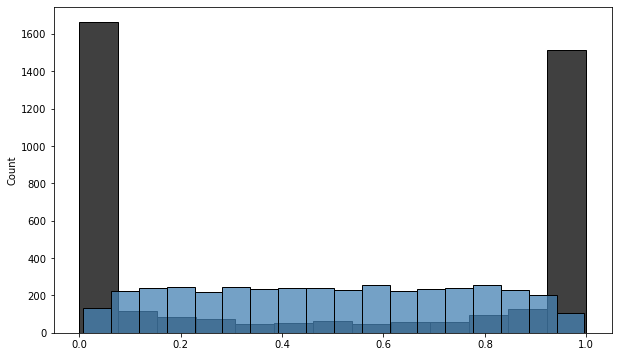

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.histplot(prior_11_1['p'], ax=ax, color='k');
sns.histplot(prior_11_1_base['p'], ax=ax, color='steelblue');

## Priors for the treatment effects

In [11]:
with pm.Model() as m_11_2:
    a = pm.Normal('a', mu=0, sigma=1.5)
    b = pm.Normal('b', mu=0, sigma=10, shape=df['treatment'].nunique())
    p = pm.Deterministic('p', pm.math.invlogit(a + b[df['treatment']]))
    pulled_left = pm.Binomial('pulled_left', n=1, p=p, observed=df['pulled_left'])
    
    prior_11_2 = pm.sample_prior_predictive(4000)


In [12]:
prior_11_2['p'].shape

(4000, 504)